## Project: Practice decision tree regressor problem using 2D synthetic data
## Author: Pratham Singh
## Date: 16/11/2025

## Goal:
### "Predict the target column data using 2D synthetic features. Evaluate model stability and generalization."

### 1. Imports & Configuration

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

### 2. Dataset: Create 2D synthetic

In [ ]:
# X : features, y : target
X, y = make_regression(n_features=2, n_samples=500, noise=0.5, random_state=42)
print(X.shape, y.shape)

(500, 2) (500,)


In [ ]:
data = {'X1': X[:, 0], 'X2': X[:, 1], 'y': y}
df = pd.DataFrame(data=data)
df.head(10)

,X1,X2,y
0,0.610586,0.380198,12.413557
1,-0.546859,-0.573662,-14.560850
2,0.122010,-0.575638,-8.026138
3,-1.503143,-0.259591,-19.800898
4,-0.032695,0.384065,5.496746
5,0.813510,0.825416,21.986906
6,-0.937825,-1.377669,-31.836009
7,0.130741,-0.440044,-6.124931
8,-0.099176,0.650201,9.547785
9,-1.412304,-0.908024,-30.243594


In [ ]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      500 non-null    float64
 1   X2      500 non-null    float64
 2   y       500 non-null    float64
dtypes: float64(3)
memory usage: 11.8 KB


,X1,X2,y
count,500.000000,500.000000,500.000000
mean,0.035063,0.003601,0.502898
std,0.991967,0.967035,19.040981
min,-2.423879,-3.241267,-64.702038
25%,-0.659287,-0.629572,-12.405114
50%,0.028321,0.018426,0.232545
75%,0.702322,0.609464,12.602817
max,3.852731,3.078881,64.412922


### 3. Exlanatory Data Analysis (EDA)

### 3.1 Target Distribution

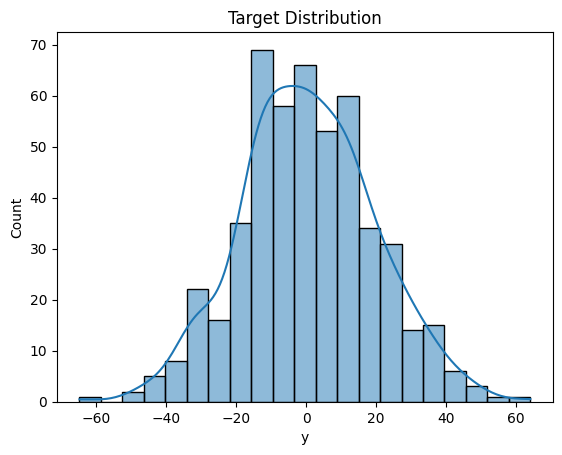

In [ ]:
sns.histplot(df['y'], kde=True)
plt.title("Target Distribution")
plt.show()

### 3.2 Feature visuals

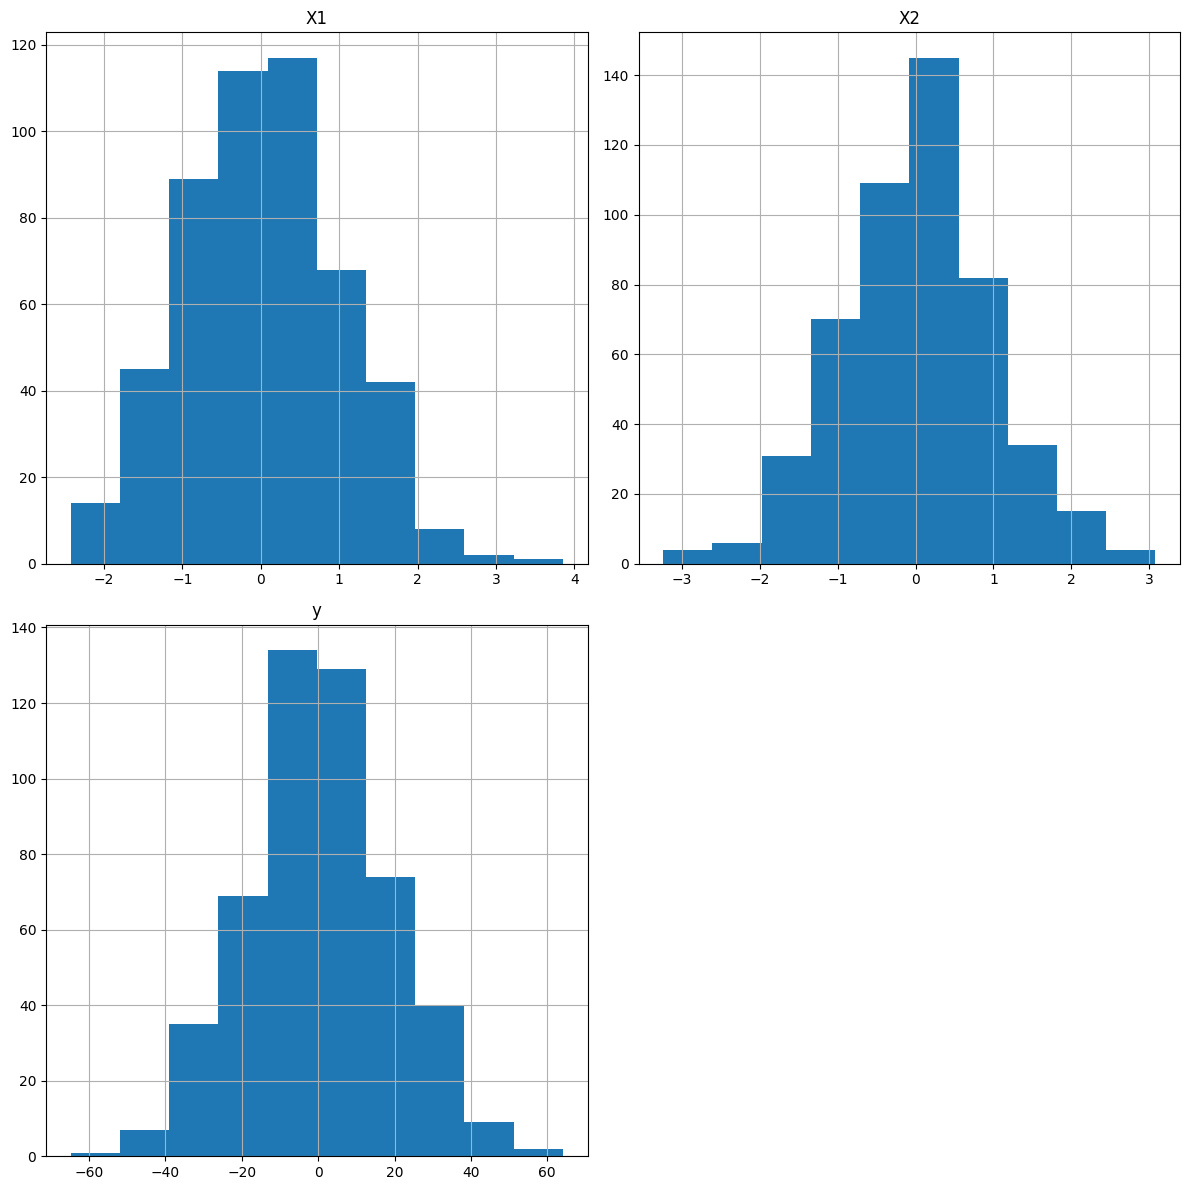

In [ ]:
df.hist(figsize=(12,12))
plt.tight_layout()
plt.show()

### 3.3 Correlation Heatmap

<Axes: >

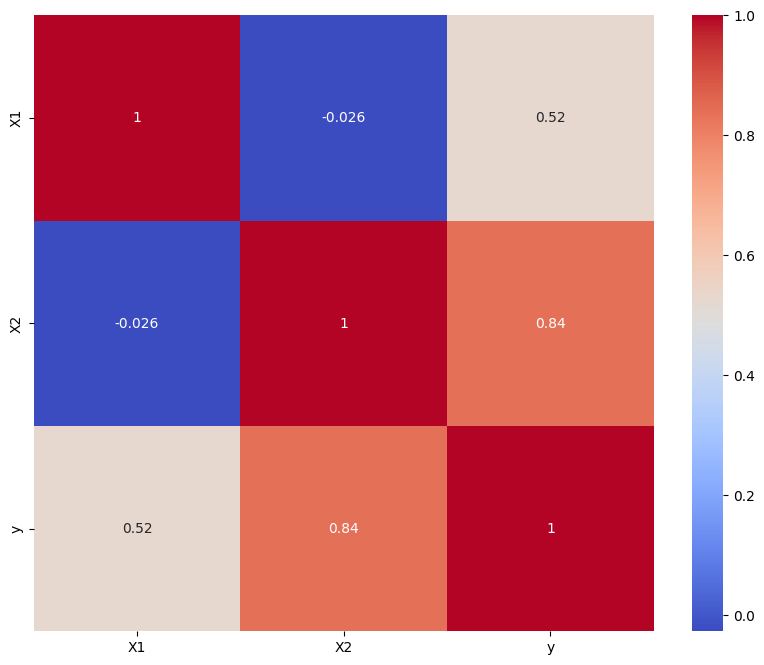

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")

### 4. Train-Test Split

In [57]:
X = df.drop('y', axis=1)
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 5. Baseline Model
A baseline model is the simplest possible model you compare all your ML models against.

If your “smart model” can’t beat the baseline →
Your model is worthless. Stop. Fix upstream issues.

This prevents wasted time and fake confidence.

In [ ]:
# Baseline prediction = mean of training target
baseline_pred = np.full_like(y_test, fill_value=y_train.mean(), dtype=float)

print("Baseline MSE:", mean_squared_error(y_test, baseline_pred))
print("Baseline R2:", r2_score(y_test, baseline_pred))

Baseline MSE: 341.508223710864
Baseline R2: -0.003794362659587769


Note: After baseline test, the baseline MSE: ~342 and R2 score: -0.0038 = ~ 0. So, it means Model MSE < 342 and R2 score > 0

###  7. Train First Model (Benchmark Model)

In [46]:
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

### 8. Model Evaluation (Basic)

In [47]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

print("Train R2:", r2_score(y_train, pred_train))
print("Test R2:", r2_score(y_test, pred_test))
print("Test MSE:", mean_squared_error(y_test, pred_test))

Train R2: 1.0
Test R2: 0.9677605388069193
Test MSE: 10.968422950964637


Result: Trained data is Overfit

### 9. Cross-Validation (Generalization Check)

In [48]:
scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print("CV Mean:", scores.mean())
print("CV Std:", scores.std())

CV Mean: 0.9632845288705199
CV Std: 0.015971819307795187


### 10. Hyperparameter Tuning (GridSearchCV)

In [52]:
param_grid = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
}

grid = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='r2'
)

grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': [3, 5, 7, None],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10]},
             scoring='r2')

In [53]:
print("Best Params:", grid.best_params_)
print("Best CV Score:", grid.best_score_)
best_model = grid.best_estimator_

Best Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV Score: 0.942103761391407


### 11. Error Analysis (Critical Step)

### 11.1 Residual Plot

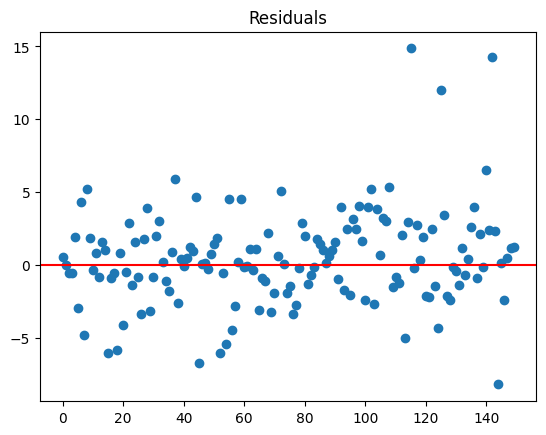

In [54]:
residuals = y_test - best_model.predict(X_test)
plt.scatter(range(len(residuals)), residuals)
plt.axhline(0, color='red')
plt.title("Residuals")
plt.show()

### 12. Feature Importance (Trees)

In [58]:
importances = best_model.feature_importances_
pd.Series(importances, index=X.columns).sort_values(ascending=False)

,0
X2,0.715916
X1,0.284084


### 13. Final Evaluation

In [59]:
print("Final R2:", r2_score(y_test, best_model.predict(X_test)))
print("Final MSE:", mean_squared_error(y_test, best_model.predict(X_test)))

Final R2: 0.9677605388069193
Final MSE: 10.968422950964637


### 14. Save Artifacts

In [61]:
import joblib
joblib.dump(best_model, "model.pkl")

['model.pkl']